**AIM:**
  
  
  - The ongoing Corona outbreak has caused significant drops in revenue for US bike-sharing company BoomBikes. <br>It has made the conscious decision to develop a business plan that would enable it to boost sales as soon as the current lockdown ends.

  - The goal of the company is:
    
    - To determine factors (like <span style='color:green'>weathersit</span>, <span style='color:green'>season</span>, <span style='color:green'>yr</span>) that may influence the demand for these shared bikes in the US market.

    - To develop a model based on those factors, that would explain the variations in the demand for these shared bikes
    
    - To know the R-squared of the model, i.e. how well those factors capture consumer demand for bikes. 

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.3f}'.format

In [2]:
bike_rental_data = pd.read_csv('day.csv', header=0, sep=',')

In [3]:
bike_rental_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.111,18.181,80.583,10.750,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.903,17.687,69.609,16.652,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.051,9.470,43.727,16.637,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200,10.606,59.044,10.740,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305,11.463,43.696,12.522,82,1518,1600


In [4]:
bike_rental_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


#### Fixing columns
1) `dteday` - It is a date column. Rename it to <span style='color:green'>dtedate</span>

In [5]:
bike_rental_data.rename(columns={'dteday':'dtedate'}, inplace=True)

2) Drop irrelevant columns
    - The overall number of bike rentals, including <span style='color:purple'>registered</span> and <span style='color:purple'>casual</span> ones, is reflected in the variable `cnt`. <br>Since it is the one that will be utilized as the target variable to construct the model, we can eliminate the following variables
      - casual
      - registered
    
    - **instant** is an identifier; it is not analytically useful factual data. It is therefore droppable.

In [6]:
bike_rental_data.drop(['casual', 'registered', 'instant'], axis=1, inplace=True)

#### Missing values
 - Determine the percentage of missing values in each column

In [7]:
perc_missing = bike_rental_data.isna().sum(axis=0)/len(bike_rental_data)*100
perc_missing[perc_missing>0]

Series([], dtype: float64)

> <span style='color:purple'><u>Interpretation</u></span></ul> - No missing vaues found

#### Invalid Values
- `dtedate` - dates are available as strings, so parse them into datetime objects.

In [8]:
bike_rental_data.dtedate = pd.to_datetime(bike_rental_data.dtedate, format='%d-%m-%Y')

#### Derive metric from dates
1) Extract <span style="color:green">day</span> as a ***Type Driven Metric*** from `dtedate` column, which is missing in the dataframe

In [9]:
bike_rental_data['day'] = bike_rental_data.dtedate.map(lambda x:x.day)

2) Extract <span style="color:green">weekday_name</span> as a ***Type Driven Metric*** from `dtedate` column for analysis. 
   
   - Weekdays are from 0 to 6. 
   
   - <span style='color:blue'>**0**</span> is for <span style='color:blue'>Tuesday</span> and <span style='color:purple'>**6**</span> is for <span style='color:purple'>Monday</span>

In [10]:
bike_rental_data['weekday_name'] = bike_rental_data.weekday.map(
    {0:'Tuesday', 1:'Wednesday', 2:'Thursday',3:'Friday', 4:'Saturday', 5:'Sunday', 6:'Monday'}
)

3) Drop the <u>dtedate</u> column as we have the relevant metrics like <span style="color:green">day, mnth, yr</span> etc. in the dataframe

In [11]:
bike_rental_data.drop('dtedate', axis=1, inplace=True)

#### Convert few quantitative variables into qualitative variables
1) Check the unique values in **weathersit**, **season**, **yr**

In [12]:
# unique values in 'weathersit'
bike_rental_data.weathersit.unique()

array([2, 1, 3])

In [13]:
# unique value in 'season'
bike_rental_data.season.unique()

array([1, 2, 3, 4])

In [14]:
# unique values in 'yr'
bike_rental_data.yr.unique()

array([0, 1])

2) Below are ***Categorical*** features. <br>Used the data dictionary to replace the feature values with following categorical string values so that we can better comprehend them.

    - `weathersit` (has [<span style='color:blue'>1, 2, 3</span>] as unique values):
      - 1: <span style='color:blue'>clear_or_cloudiness</span> for (Clear, Few clouds, Partly cloudy, Partly cloudy)
      - 2: <span style='color:blue'>misty_clouds</span> for (Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist)
      - 3: <span style='color:blue'>precipitation</span> for (Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds)

    - `season` (has [<span style='color:green'>1, 2, 3, 4</span>] as unique values):
      - 1: <span style='color:green'>spring</span>
      - 2: <span style='color:green'>summer</span>
      - 3: <span style='color:green'>fall</span>
      - 4: <span style='color:green'>winter</span>
    
    - Column `yr` has two integer values <span style='color:purple'>0</span> and <span style='color:purple'>1</span>. Replace them into the years <span style='color:purple'>2018</span> and <span style='color:purple'>2019</span> respectively.

In [15]:
# 'weathersit' has [1, 2, 3] as unique values
bike_rental_data.weathersit = bike_rental_data.weathersit.map({1:'clear_or_cloudiness', 2:'misty_clouds', 3:'precipitation'})

# 'season' has [1, 2, 3, 4] as unique values
bike_rental_data.season = bike_rental_data.season.map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})

# 'yr' has [0, 1] as unique values
bike_rental_data.yr = bike_rental_data.yr.map({0:'2018', 1:'2019'})

#### Check for duplicate rows

In [16]:
bike_rental_data.duplicated().sum()

0

> <span style='color:purple'><u>Interpretation</u></span></ul>: <br>No duplicate rows found in the dataframe.

#### Explore the datatype of each column and the number of unique values in them

In [17]:
bike_rental_data.nunique(axis=0).sort_values(ascending=False).to_frame('num_unique_val').join(
    bike_rental_data.dtypes.to_frame('datatypes'),
    how='inner'
)

,num_unique_val,datatypes
cnt,695,int64
atemp,689,float64
windspeed,649,float64
hum,594,float64
temp,498,float64
day,31,int64
mnth,12,int64
weekday,7,int64
weekday_name,7,object
season,4,object


#### **Univariate Analysis on Quantitative Variables**

In [18]:
# select the numerical columns for the below analysis
num_cols = bike_rental_data.select_dtypes(exclude = object).keys()

# date related columns 'mnth', 'day', 'weekday' can be eliminated
num_cols = num_cols.drop(['mnth', 'day', 'weekday'])

# drop unordered categorical columns 'holiday' and 'workingday'
num_cols = num_cols.drop(['workingday', 'holiday'])

In [19]:
num_cols

Index(['temp', 'atemp', 'hum', 'windspeed', 'cnt'], dtype='object')

1) Create a function to plot multiple historams using subplots

In [20]:
def plot_multiple_histograms_univar(dframe, colnames_idx):
    '''
    Plot histograms for univariate analysis.

    Params:
      dframe: Dataframe to read
      colnames_idx: Array of column names to access in the dataframe
    '''
    if not isinstance(colnames_idx, np.ndarray):
        raise TypeError('"colnames_idx" must be a numpy array')
    if isinstance(dframe, pd.DataFrame):
        try:
            fig, ax = plt.subplots(nrows=3, ncols=2, sharex=False, sharey=False)
            fig.set_size_inches(11, 11)
            for colnames, axes in zip(colnames_idx, [(0, 0), (0, 1),
                                                     (1, 0), (1, 1),
                                                     (2, 0)]):
                num, bin, _ = ax[axes[0], axes[1]].hist(x=dframe[colnames], bins=50, edgecolor='red', color='cyan')
                ax_kde= ax[axes[0], axes[1]].twinx()
                sns.kdeplot(dframe[colnames], ax=ax_kde, color='purple')
                ax[axes[0], axes[1]].set_xlabel(colnames, color='red')
                sorted_bins = sorted(zip(np.round(num, 1), zip(np.round(bin[:-1], 1), np.round(bin[1:], 1))),
                                     key=lambda x:x[0],
                                     reverse=True)
                ax[axes[0], axes[1]].set_title(f'most common bin: {sorted_bins[0][1]} \n2nd most common bin: {sorted_bins[1][1]} \nmin: {bin.min().astype(int)},  max: {bin.max().astype(int)} \nskew: {round(dframe[colnames].skew(), 2)},  kurtosis: {round(dframe[colnames].kurtosis(), 2)}',
                                               fontsize=9, fontweight=30, color='black', loc='left')
                ax_kde.set_ylabel('')
                ax_kde.tick_params(labelright=False)
            ax[2, 1].set_axis_off()
            fig.tight_layout()
            fig.suptitle('Frequency Distribution + KDE of numerical columns', fontsize=15, color='blue', x=0.5, y=1.05)
            # fig.supylabel('Frequency', fontsize=15, color='blue', x=0, y=.53)
            fig.show()
        except Exception as e:
            raise e
    else:
        raise TypeError('"dframe" must be a dataframe object')        

2) Plot Histograms to visualize the frequency distribution of those <span style='color:blue'>6 numerical columns</span>

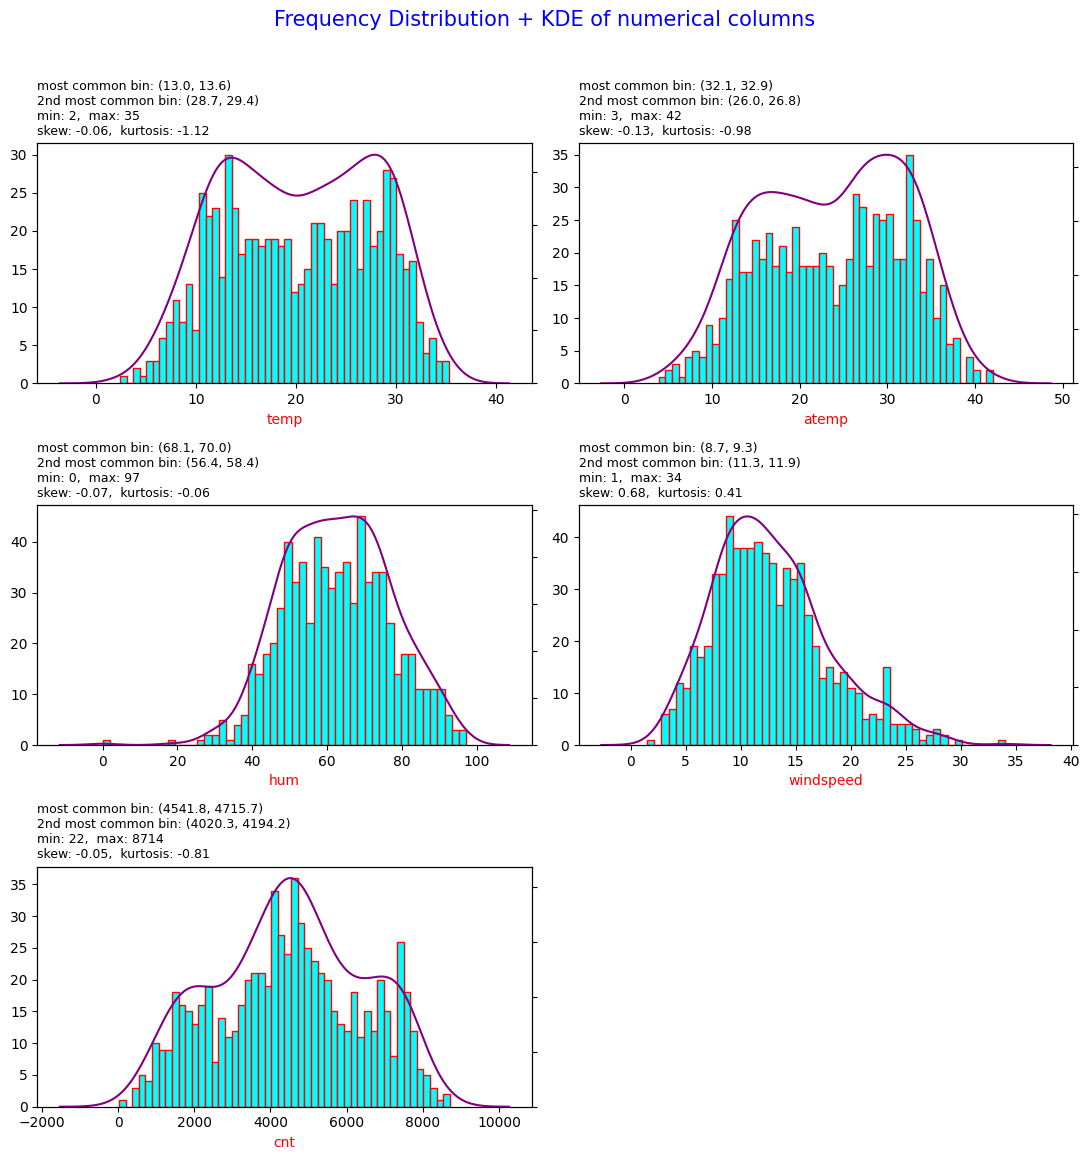

In [21]:
plot_multiple_histograms_univar(bike_rental_data, num_cols.values)

- <span style='color:purple'>Interpretations from above histograms</span>


  - Each variable's minimum and maximum values are shown in the plots, along with the most common bins—that is, the ranges within which most values that are similar fall. 
  
  - Skewness tells us about the asymmetry of the disribution. <br>Kurtosis tells us about the tailedness of the distribution.

  - A few extreme values in the variables `hum` and `windspeed` indicate the presence of outliers.

  - Most favorable atmospheric **temp** (or **atemp**) to rent bikes is in between 11 to 32 degrees Celsius, indicating that at extreme cold or extreme hot weather, there is a lower likelihood of renting bikes.

  - **hum** - It is less comfortable for customers to rent bikes in less humid weather (<46) or extremely humid weather (>84).

  - When the **windspeed** is between 7 and 17, it seems to be manageable for riding bikes.

  - **cnt** - In 2018/19, the company appears to have catered bike rentals in the range of 4000–4700 on average.

#### **Detect outliers and treat them as missing values in the meantime**

1) **Strategy to detect outliers**
  
   - Eliminating outliers that fall beyond the interquartile range (IQR) or using Tukey's boxplot method that identifies outliers outside of the range `(q1-1.5*IQR)` and `(q3+1.5*IQR)`, we may end up losing vital information from the dataset.

   - Instead we will detect outliers on the basis of the percentile values
     - If the 100th percentile value is greater than the 99th percentile value then the 100th percentile value is an outlier.
     - So, we can evaluate the <span style='color:green'>growth rate of the subsequent percentile values</span> and compare them such that if the higher percentile values grow much larger compared to the lower percentile values, that will indicate the presence of outliers.

2) Meantime, ***let's impute the outliers as missing values for now.*** <br>Afterwards, we will decide whether to eliminate these anomalies or substitute them with appropriate values before sending the data to the model.

In [22]:
def detect_and_treat_outliers(dframe, 
                              numerical_column_name, 
                              treat_outliers_flag:bool=False,
                              commit_change:bool=False, 
                              lower_index:int=0, 
                              higher_index:int=99):
    '''
    Calculate the growth rate between the consecutive percentile quantities to determine outliers. 
    Once detected, inpute them with missing values

    Params:
      dframe: A datafrmae to access
      numerical_column_name: Name of a numerical column in the dataframe
      treat_outliers_flag: 
         Default to False, will return the growth rate between the consecutive percentile values.
         Setting to True, will return the specified column with values bounded within the desired quantiles.
      commit_change:
         Default to False, (same as treat_outliers_flag==True) 
         Setting to True, will impute the outliers as missing values
      lower_index: an interger to determine the lower bound quantile
      higher_index: an interger to determine the upper bound quantile
    
    Returns:
       A dataframe w.r.t. the state of the treat_outliers_flag variable.
    '''
    if not isinstance(numerical_column_name, str):
        raise TypeError('Arg "numerical_column_name" must be a str.')
    if not isinstance(treat_outliers_flag, bool) and not isinstance(commit_change, bool):
        raise TypeError('Arg(s) "treat_outliers_flag" & "commit_change" must be of bool types.')
    if not isinstance(lower_index, int) and not isinstance(higher_index, int):
        raise TypeError('Arg(s) passed to "lower_index" & "higher_index" must be of int types.')
    if isinstance(dframe, pd.DataFrame):
        try:
            quantile_values = np.percentile(dframe[numerical_column_name].dropna(), range(0, 101))
            if not treat_outliers_flag:
                percentile_growth = np.ediff1d(quantile_values, to_end=0)
                percentile_growth = np.divide(percentile_growth,
                                              quantile_values,
                                              where=quantile_values!=0)
                # print(quantile_values[95])
                return pd.DataFrame({'growth_rate': percentile_growth*100,
                                     'consecutive-percentiles':[f'{x-1}, {x}' for x in range(1, 101)]+[f'100, NA']})[-1::-1]
            else:
                lower_bound = quantile_values[lower_index]
                upper_bound = quantile_values[higher_index]
                # print(upper_bound)
                if commit_change:
                    filter_cond_commit = (dframe[numerical_column_name] < lower_bound) | (dframe[numerical_column_name] > upper_bound)
                    dframe[numerical_column_name][filter_cond_commit] = np.nan
                else:
                    filter_cond_chk = (dframe[numerical_column_name] > lower_bound) & (dframe[numerical_column_name] < upper_bound)
                    return dframe[numerical_column_name][filter_cond_chk]
        except Exception as e:
            raise e
    else:
        raise TypeError('Arg "dframe" mmust be a pd.DataFrame object.')

1) <span style='color:blue'>***hum***</span> - detect outliers using the above strategy

In [23]:
detect_and_treat_outliers(bike_rental_data, numerical_column_name='hum', treat_outliers_flag=False).tail(30)

,growth_rate,consecutive-percentiles
29,0.618,"29, 30"
28,0.324,"28, 29"
27,0.973,"27, 28"
26,1.271,"26, 27"
25,0.947,"25, 26"
24,0.906,"24, 25"
23,1.466,"23, 24"
22,0.315,"22, 23"
21,0.468,"21, 22"
20,0.838,"20, 21"


- After imputing the outliers with missing data, confirm the value of the column <span style='color:blue'>***hum***</span>. The change won't be committed just yet. <br>Utilize boxplots and distplots to verify

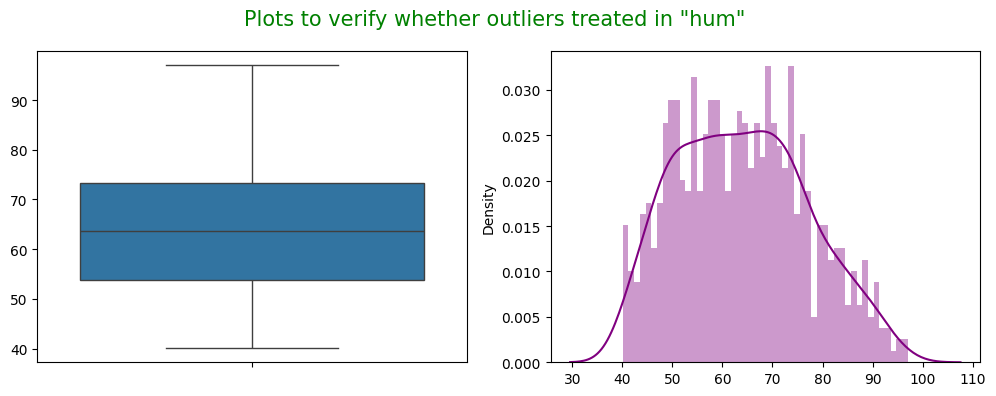

In [24]:
check_hum = detect_and_treat_outliers(bike_rental_data,
                                      numerical_column_name='hum',
                                      treat_outliers_flag=True,
                                      commit_change=False,
                                      lower_index=4,
                                      higher_index=100)

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(10, 4)
sns.boxplot(check_hum, ax=ax[0])
sns.distplot(check_hum, bins=50, kde=True, ax=ax[1], color='purple')
ax[0].set_ylabel('')
ax[1].set_xlabel('')
fig.suptitle('Plots to verify whether outliers treated in "hum"', fontsize=15, color='green')
fig.tight_layout()
fig.show()

- Replace the outliers in <span style='color:blue'>***hum***</span> as missing values and commit the change.

In [25]:
detect_and_treat_outliers(bike_rental_data,
                          numerical_column_name='hum',
                          treat_outliers_flag=True,
                          commit_change=True,
                          lower_index=4,
                          higher_index=100)

> Same strategy will be continued for other selected numerical column, to detect outliers and treat them as missing values

2. <span style='color:blue'>***windspeed***</span> - detect outliers and replace them with missing values

In [26]:
detect_and_treat_outliers(bike_rental_data, numerical_column_name='windspeed', treat_outliers_flag=False).head(30)

,growth_rate,consecutive-percentiles
100,0.000,"100, NA"
99,24.174,"99, 100"
98,8.648,"98, 99"
97,5.010,"97, 98"
96,2.988,"96, 97"
95,1.317,"95, 96"
94,2.504,"94, 95"
93,4.371,"93, 94"
92,4.232,"92, 93"
91,1.352,"91, 92"


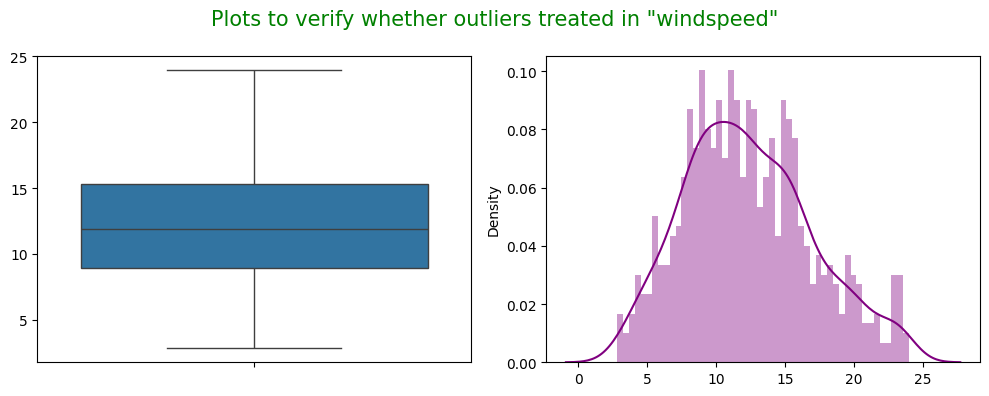

In [27]:
check_windspeed = detect_and_treat_outliers(bike_rental_data,
                                            numerical_column_name='windspeed',
                                            treat_outliers_flag=True,
                                            commit_change=False,
                                            lower_index=0,
                                            higher_index=97)

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(10, 4)
sns.boxplot(check_windspeed, ax=ax[0])
sns.distplot(check_windspeed, bins=50, kde=True, ax=ax[1], color='purple')
ax[0].set_ylabel('')
ax[1].set_xlabel('')
fig.suptitle('Plots to verify whether outliers treated in "windspeed"', fontsize=15, color='green')
fig.tight_layout()
fig.show()

In [28]:
detect_and_treat_outliers(bike_rental_data,
                          numerical_column_name='windspeed',
                          treat_outliers_flag=True,
                          commit_change=True,
                          lower_index=0,
                          higher_index=97)

#### **Univariate Analysis on Categorical Variables**

- Create a function to visualize bar plots for univariate analysis on categorical variables

In [29]:
def create_bar_plots_univar(dframe, colname, W, H, width,
                            rotate:bool=False,
                            annotate_flag:bool=True,
                            convert_to_str:bool=False):
    '''
    Create bar plots for univariate analysis
    
    Params:
       dframe: A dataframe to read
       colname: Name of the column to access in the dataframe
       W: A number to set the width of the plot
       H: A number to set the height of the plot
       width: A number to set the width of the bars in the plot
       rotate: Setting to True, will rotate the xticks
       annotate_flag: Default to True, will add annotations to the plot
    '''
    try:
        fig = plt.figure()
        ax = plt.subplot()
        fig.set_size_inches(w=W, h=H)
        freq = dframe[colname].value_counts()
        rand_colors = np.random.choice(['yellow', 'pink', 'cyan'],
                                        1,
                                        replace=False)
        if convert_to_str:
            freq.index = freq.index.astype(str)
        ax.bar(x=freq.index, height=freq, width=width, edgecolor='red', align='center', color=rand_colors)
        ax.set_ylabel('count', fontdict=dict(fontsize=11, fontweight=20, color='green', fontstyle='oblique'))
        ax.set_title(f'{colname}',
                         fontdict=dict(fontsize=12, fontweight=20, color='purple', fontstyle='oblique'))
        if rotate:
            plt.xticks(rotation=90)
        if annotate_flag:
            for i in zip(freq.index, freq):
                ax.annotate(xy=i, text=f'{round(i[1]/freq.sum()*100, 1)}%', horizontalalignment='left', verticalalignment='bottom')
        fig.show()
    except Exception as e:
        raise

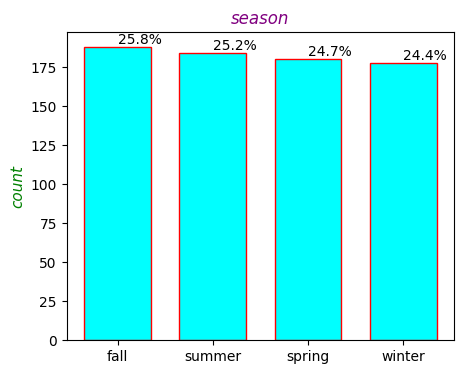

In [30]:
create_bar_plots_univar(bike_rental_data, 'season', W=5, H=4, width=.7, annotate_flag=True, rotate=False)

- <span style='color:blue'>Interpretation</span>

  - Seasonal variations are not very noticeable.

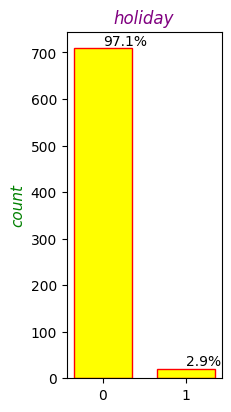

In [31]:
create_bar_plots_univar(bike_rental_data, 'holiday', W=2, H=4.5, width=.7, annotate_flag=True, rotate=False, convert_to_str=True)

- <span style='color:blue'>Interpretation</span>

  - The demand for bikes declines greatly on holidays. <br>Approximately 3% of rentals throughout the holidays in the past two years. <br>Holidays are typically harmful for its business. In 2018–19, there are a total of <span style='color:green'>**21**</span> holidays.

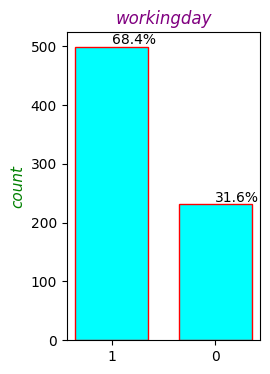

In [32]:
create_bar_plots_univar(bike_rental_data, 'workingday', W=2.5, H=4, width=.7, annotate_flag=True, rotate=False, convert_to_str=True)

- <span style='color:blue'>Interpretation</span>

  - It looks like the demand for bikes on the weekends or holidays is about half that during workdays. There were 499 working days in past 2 years

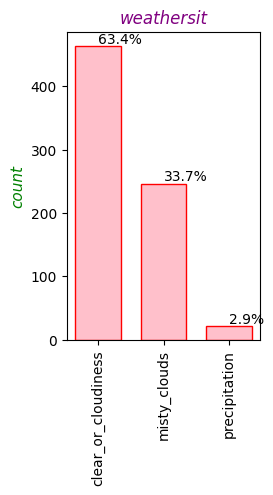

In [33]:
create_bar_plots_univar(bike_rental_data, 'weathersit', W=2.5, H=4, width=.7, annotate_flag=True, rotate=True)

- <span style='color:blue'>Interpretation</span>

  - The demand for bike rentals is almost twice as high in pleasant weather as it is in foggy/misty conditions, and it falls off significantly in the event of a thunderstorm, precipitation, etc. unpleasant weather

#### **Segmented Univariate Analysis**

1) Examine the demand for bike rentals by <span style='color:blue'>day</span>, <span style='color:blue'>weekday</span> and <span style='color:blue'>mnth</span>

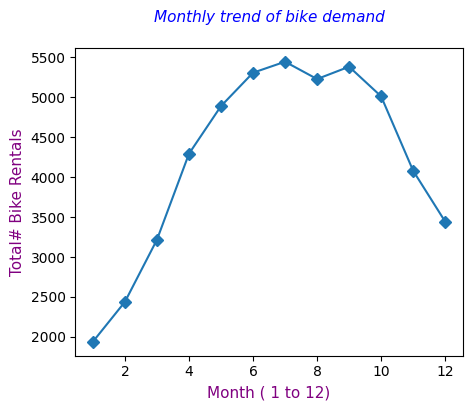

In [34]:
fig = plt.figure()
fig.set_size_inches(w=5, h=4)
plt.plot(bike_rental_data.groupby('mnth')['cnt'].median(), marker='D')
plt.xlabel('Month ( 1 to 12)', fontsize=11, fontweight=20, fontstyle='normal', color='purple')
plt.ylabel('Total# Bike Rentals', fontsize=11, fontweight=20, fontstyle='normal', color='purple')
plt.title('Monthly trend of bike demand\n', fontsize=11, fontweight=20, fontstyle='oblique', color='blue')
plt.show()

- <span style='color:purple'>Interpretation</span>

  - The overall number of bike rentals increased in the first 6 to 7 months over the span of 2018-19, then it remained consistent for the next couple of months and then the demand dropped from 9 month onwards.  

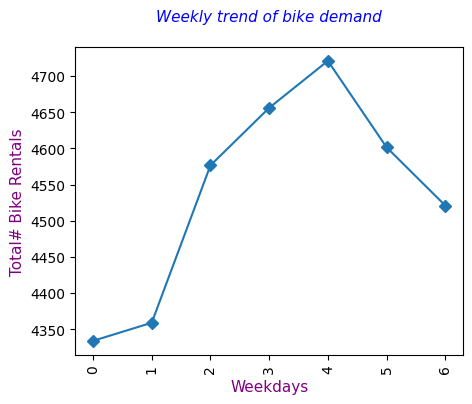

In [35]:
fig = plt.figure()
fig.set_size_inches(w=5, h=4)
plt.plot(bike_rental_data.groupby('weekday')['cnt'].median(), marker='D')
plt.xlabel('Weekdays', fontsize=11, fontweight=20, fontstyle='normal', color='purple')
plt.ylabel('Total# Bike Rentals', fontsize=11, fontweight=20, fontstyle='normal', color='purple')
plt.title('Weekly trend of bike demand\n', fontsize=11, fontweight=20, fontstyle='oblique', color='blue')
plt.xticks(rotation=90)
plt.show()

- <span style='color:purple'>Interpretation</span>

  - The number for rentals is lowest on Tuesday and Wednesday (i.e. 0 and 1 respectively), which incerases significantly on Wednesday (i.e. 2), and continue to increase until Friday (i.e. 4), which drops over the weekends, indicating likelihood of bike demand is lower in Saturday or Sunday. 

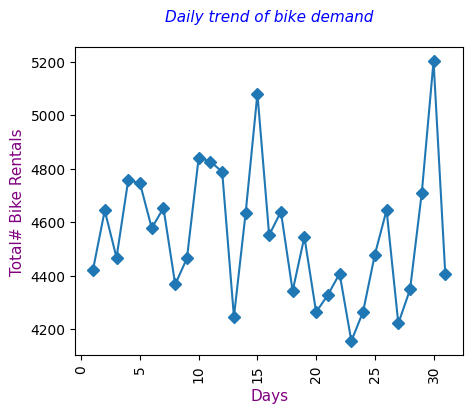

In [36]:
fig = plt.figure()
fig.set_size_inches(w=5, h=4)
plt.plot(bike_rental_data.groupby('day')['cnt'].median(), marker='D')
plt.xlabel('Days', fontsize=11, fontweight=20, fontstyle='normal', color='purple')
plt.ylabel('Total# Bike Rentals', fontsize=11, fontweight=20, fontstyle='normal', color='purple')
plt.title('Daily trend of bike demand\n', fontsize=11, fontweight=20, fontstyle='oblique', color='blue')
plt.xticks(rotation=90)
plt.show()

- <span style='color:purple'>Interpretation</span>

  - The demand for renting bikes is scattered over weekdays. Does not show any trend.
  - Looks like the this vairable does not explain the variability of the number of bike rentals. So it can be dropped from the dataframe

In [37]:
# dropping the variable 'day' from the dataframe as explained above
bike_rental_data.drop('day', axis=1, inplace=True)

2) Examine the demand for bike rentals by <span style='color:blue'>season</span>, <span style='color:blue'>holiday</span>, <span style='color:blue'>workingday</span>, <span style='color:blue'>weathersit</span> and <span style='color:blue'>yr</span> variables

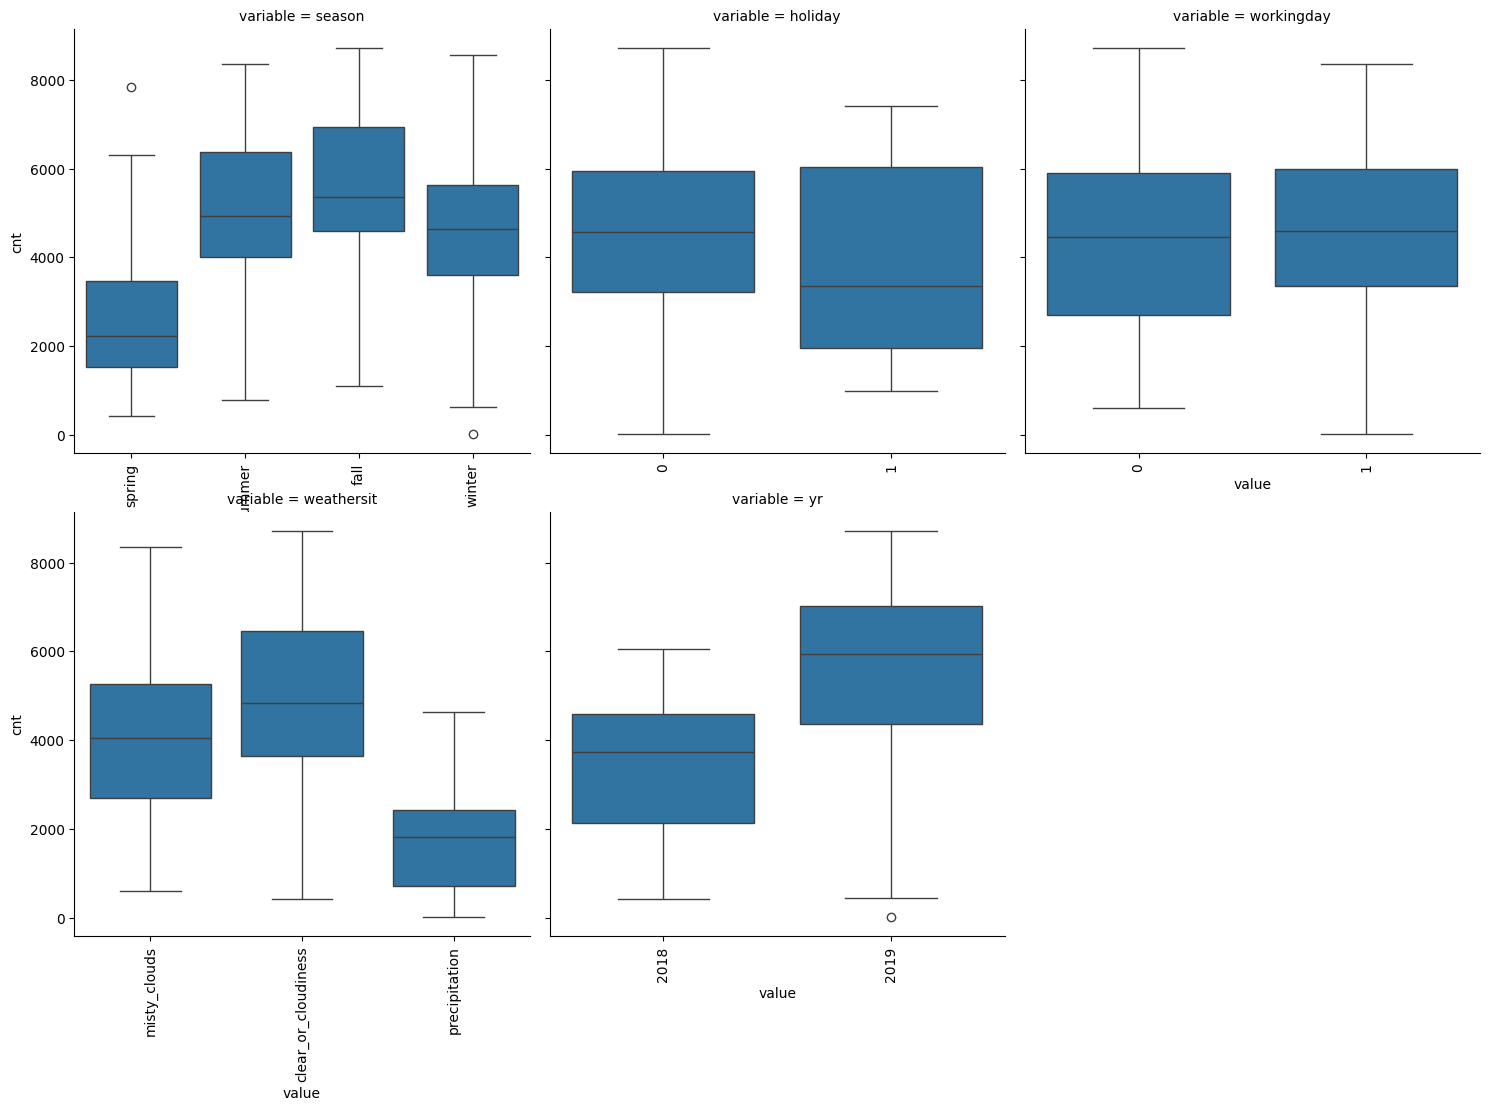

In [38]:
bike_rental_melt_data = bike_rental_data.melt(id_vars='cnt', value_vars=['season', 'holiday', 'workingday', 'weathersit', 'yr'])
facet_g = sns.FacetGrid(bike_rental_melt_data, col='variable', col_wrap=3, sharex=False, sharey=True, height=5)
facet_g.map(sns.boxplot, 'value', 'cnt')
facet_g.set_xticklabels(rotation=90)
fig.tight_layout()

- <span style='color:purple'>Interpretation</span>

  1) **holiday**
      -  The demand for bikes was higher when there were no holidays, as we saw in the univariate analysis section.  As a result, the boxplot displays that the lower quartile value of the number of bike rentals during the non-holiday period is roughly equivalent to the median of the bike rentals during the holiday period. Hence, in the event of holidays, there is a much lower likelihood of bike demand. It shows that <span style='color:blue'> this variable may influence the demand for rented bikes</span>.
      
      - But there is no significant difference in the higher quartile values. This shows that the overall number of bike rental requests vary much widely in just 21 holidays which were recorded over a period of two long years at different times/seasons, and hence the difference in mean and median could be due to randomness. We may need to perform hypothesis testing to ascertain that this mean difference is not due to randomness and is statiscally significant.

  2) **workingday** 
      - The lower quartile (q1) of the total number of bike rentals on workdays in the boxplot is larger than that on the non-working day, confirming the univariate analysis's finding that demand is higher on workdays.

      - But their higher quartile and median values do not differ significantly. It indicates that the amount of variation of the bike rental counts vary widely between working and non working day, resulting in small difference in mean, could be due to randomness. We may need to perform hypothesis testing to ascertain if the small difference in mean is statistcally significant.

  3) **yr**
     - The number of bike rentals increases very significantly from 2018 to 2019. Quartiles q1, q2, q3 - all differ very significantly over the years. <span style='color:green'>**This could be a strong influencer of bike demand**</span>. Since these bike-sharing systems are slowly gaining popularity, the demand for these bikes is increasing every year
  
  4) **season**
     - In the spring season, the number of rentals is the lowest. The 75th percentile value of the number of bike rents in spring season is lower than even the 25th percentile rents on remaining seasons. <span style='color:purple'>This indicates potential impact of season on bike rental demand, specifically in the summer, winter and fall.</span>

     - There is a gradual change in the 25th percentiles representing number of rentals from winter, to summer, & then fall. But when we compare the medians or 75th percentile values around these seasons, they do not seem to rise steadily. Also, the distributions between them vary widely, indicating the difference between their means could be due to randomness. Maybe we need to conduct hypothesis testing to ascertain if the difference in means is statiscally significant and is not due to randomness.

  5) **weathersit**
     - When the weather is pleasant, the demand of bike rentals is also appreciated. But, as the climatic condition worsen, the demand descreases. We have noticed it also during univariate analysis earlier.

     - Even the 25th percentile values of the total number of bike rentals when it is foggy or misty are lower than the higher quartile (q3) of the total number of bike rentals during unfavorable weather (precipitation or thunderstorm). It shows that <span style='color:blue'>weathersit may influence the demand for rented bikes</span>. There was hardly any occurrences of the thunderstorm like situtations which could have caused such lower bike demands at the time. 

     - In foggy or misty weather, the 75th percentile count of all bike rentals appears to be substantially lower than in pleasant weather, which is also true across their lower quartiles. The differences between the bike demands' medians in favorable and foggy conditions are not as great as those between the upper and lower quartiles, representing the bike demand variances are wide enough causing the small difference in the averages due to randomness, hinting that this variable might not influence the bike rental demand. We can conduct hypothesis testing to ascertain whether the mean difference is statistically significant and not due to randomness.

<span style="color:green">**Top Influencer** among <u>categorical columns</u> that are more likely to influence bike demand</span>

In [39]:
x = []
for i in bike_rental_data.keys().drop(num_cols):
    median_vals = bike_rental_data.groupby(i, as_index=True)['cnt'].agg('median')
    var_diff = ((median_vals.max(axis=0) - median_vals.min(axis=0))/median_vals.min(axis=0)*100).round(2)
    x.append((i, var_diff))
df = pd.DataFrame(x, columns=['influencers', f'%diff_median'])
df = df.sort_values(ascending=False, by=f'%diff_median').reset_index(drop=True)
df['rank'] = np.arange(1, len(df)+1)
df

,influencers,%diff_median,rank
0,mnth,180.890,1
1,weathersit,166.590,2
2,season,140.880,3
3,yr,58.720,4
4,holiday,36.170,5
5,weekday,8.930,6
6,weekday_name,8.930,7
7,workingday,2.830,8


- <span style='color:purple'>Interpretation</span>

  - <span style="color:blue">***mnth***, ***weathersit***, ***season***, ***yr***, ***holiday*** and ***day*** being the top influencer among the categorical variables, that would help explain the variations in the demand for these shared bikes</span>

#### **Analysis of quantitative variables to assess their impact on each other and on the target variable <span style='color:purple'>"cnt"</span>**

1) <span style='color:green'>Pairplot of numerical variables</span>

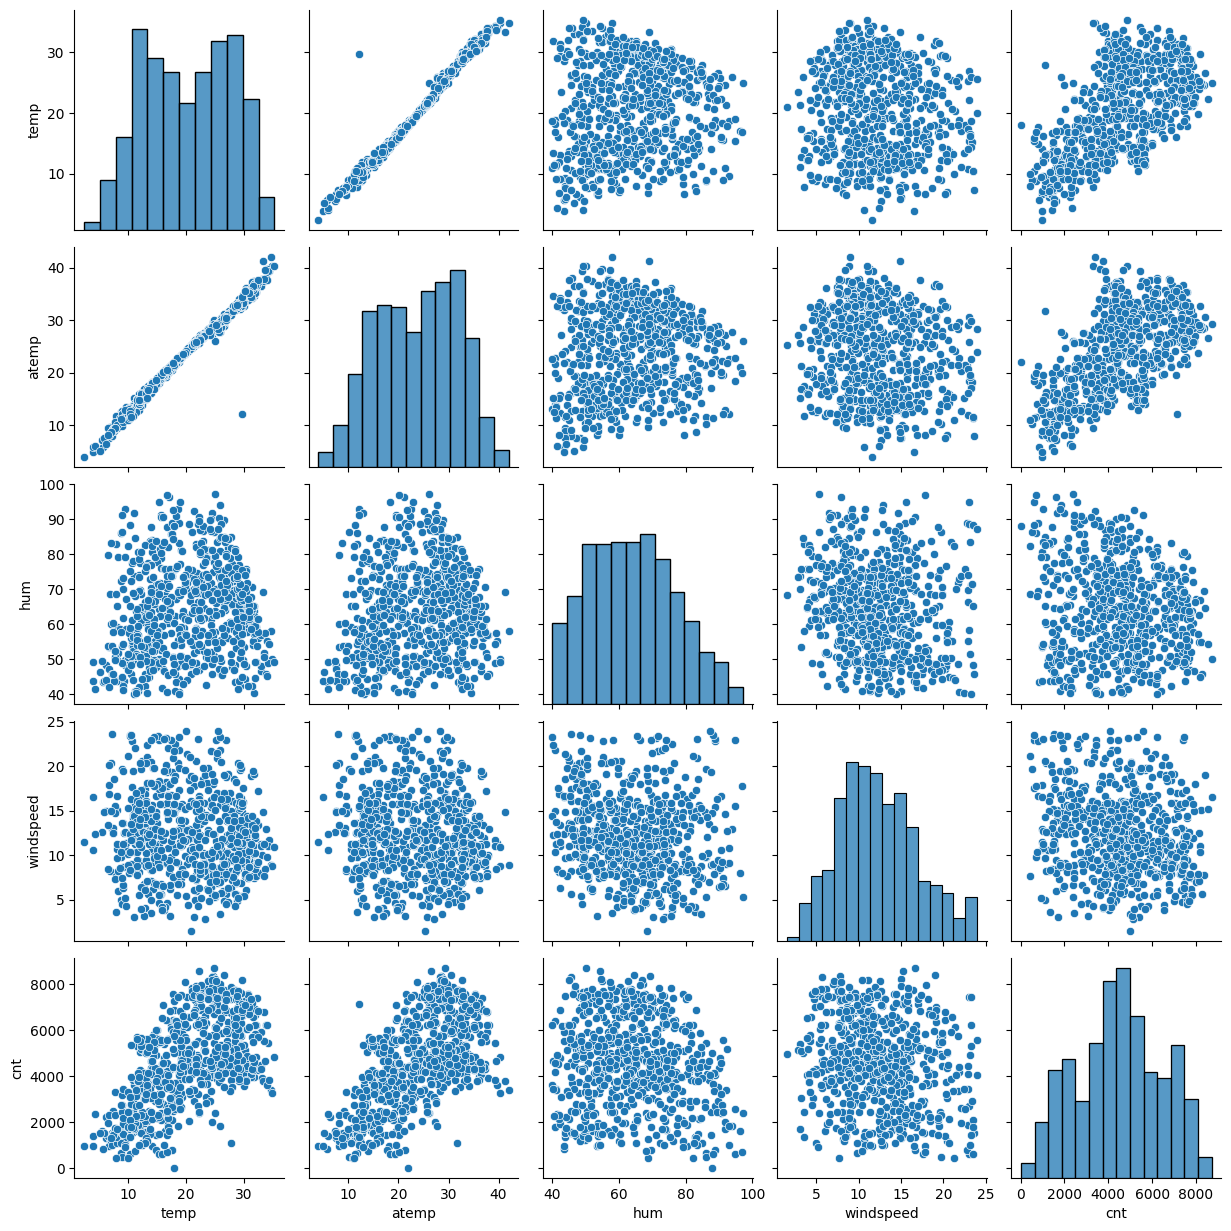

In [40]:
sns.pairplot(bike_rental_data[num_cols])
plt.show()

- <span style='color:purple'>Interpretation</span>

  - **temp** and **atemp** have a positive linear association with the target variable **cnt**. <br>Will check their correlation scores below to ascertain this dependency.

  - **atemp** and **temp** have a strong positive linear relationship. Therefore, we can drop anyone of them. <br>I'll confirm this by looking at their correlation scores down below.

  -  There appears to be no correlation between **hum** and **windspeed** and the target variable **cnt**. <br>I'll confirm this by looking into their correlation scores below.

2) <span style='color:green'>Heatmap to show Pairwise Correlations of numerical variables</span>

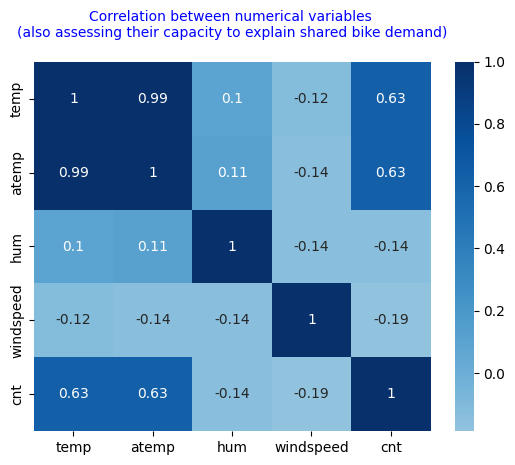

In [41]:
sns.heatmap(bike_rental_data[num_cols].corr(), annot=True, center=0, cmap='Blues')
plt.title("Correlation between numerical variables \n(also assessing their capacity to explain shared bike demand)\n",
          fontdict=dict(fontsize=10, fontweight=20, color='blue', fontstyle='normal'))
plt.show()

- <span style='color:purple'>Interpretation</span>

  - Target variable **cnt** has a high positive linear correlation with **temp** and **atemp** (correlation ~ 0.68). <br>They are most likely to explain the variance of shared bike demand among the numerical variables.

  - Strong positive linear relationship between **atemp** and **temp** (correlation ~ 0.99). Hence we can drop either one of them

  -  **hum** and **windspeed** does not seem to be correlated to the target variable **cnt**, indicating that they have less likelihood of being able to explain the shared bike demand. We can drop them from the dataset

In [42]:
# dropping the variables as explained above
bike_rental_data.drop(['temp', 'hum', 'windspeed'], axis=1, inplace=True)

# also dropping them from our numerical variable list
num_cols = num_cols.drop(['temp', 'hum', 'windspeed'])

#### **Bivariate Analysis of Categorical variables**

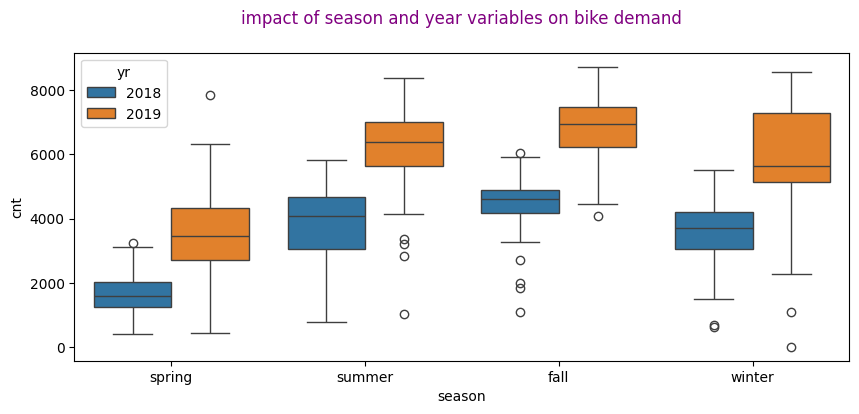

In [43]:
plt.figure(figsize = (10, 4))
sns.boxplot(x = 'season', y = 'cnt', hue = 'yr', data = bike_rental_data)
plt.title('impact of season and year variables on bike demand\n', color='purple')
plt.show()

- <span style='color:purple'>Interpretation</span>

  - As we have determined with the segmented univariate analysis, **season** and **yr** variables have potential impact on demand of rented bikes. Comparing them with each other, shows that the demand do significantly differ over the seasons across the years. Hence, <span style='color:blue'>season</span> and <span style='color:blue'>yr</span> variables are <span style='color:blue'>highly correlated</span> to each other

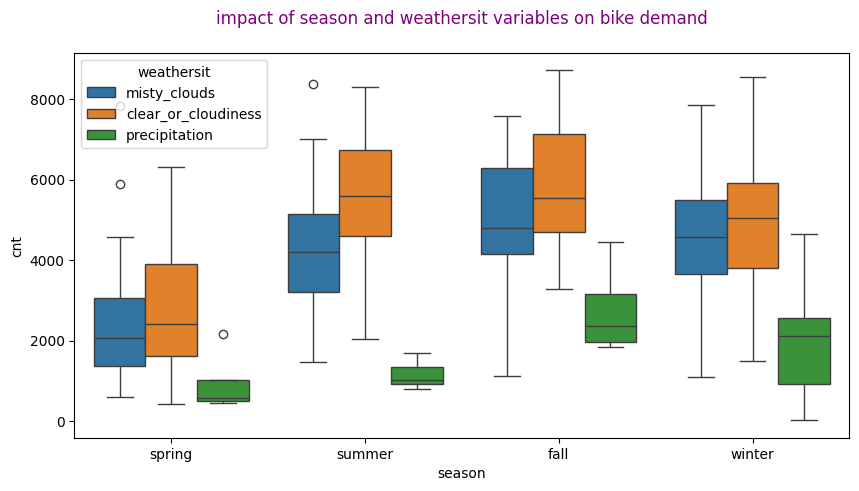

In [44]:
plt.figure(figsize = (10, 5))
sns.boxplot(x = 'season', y = 'cnt', hue = 'weathersit', data = bike_rental_data)
plt.title('impact of season and weathersit variables on bike demand\n', color='purple')
plt.show()

- <span style='color:purple'>Interpretation</span>

  - As we have determined with the segmented univariate analysis, **season** and **weathersit** may influence the demand for rented bikes. Comparing them with each other, shows that the demand differ over the seasons during unfavorable weather (precipitation or thunderstorm). But there is hardly any occurrences of such weather conditions over the span of 2018-19. Also, they do not appear to influence the overall bike rental count together. Hence, <span style='color:blue'>season</span> and <span style='color:blue'>weathersit</span> variables are <span style='color:blue'>less likely to be correlated</span> to each other.

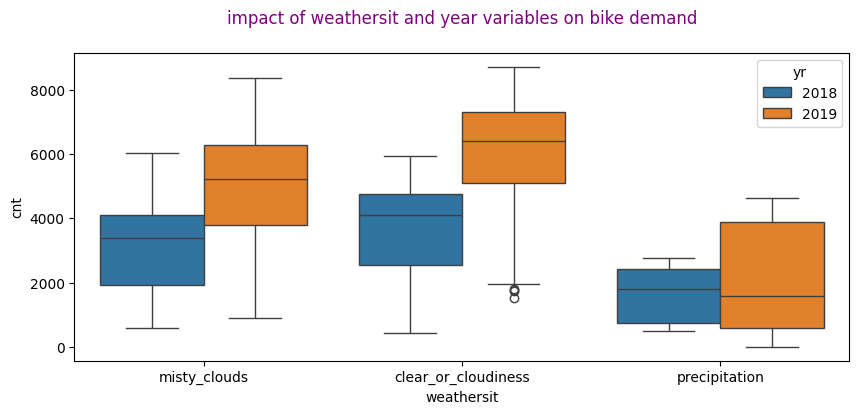

In [45]:
plt.figure(figsize = (10, 4))
sns.boxplot(x = 'weathersit', y = 'cnt', hue = 'yr', data = bike_rental_data)
plt.title('impact of weathersit and year variables on bike demand\n', color='purple')
plt.show()

- <span style='color:purple'>Interpretation</span>

  - As we have determined with the segmented univariate analysis, The **yr** and **weathersit** may have an impact on the demand for rental bikes. When comparing them to one another, it is clear that demand for shared bikes has changed over time depending on whether the weather is clear or cloudy. This is supported by the lower quartile, upper quartile, median counts of rental bikes. But, during unpleasant climatic conditions, the demand do not differ much over the years. There was hardly any occurrences of the thunderstorm like situtations which could have caused such lower bike demands at the time. Hence, <span style='color:blue'>yr</span> and <span style='color:blue'>weathersit</span> variables appear to have <span style='color:blue'>correlation</span> with each other.

#### **Data Preparation**

1) At first, drop the <span style='color:purple'>weekday</span> column from the dataframe. <br>We will use <span style='color:purple'>weekday_name</span> instead

In [46]:
bike_rental_data.drop('weekday', axis=1, inplace=True)

2) Create dummy variables for **weathersit** and **season** variables

   - `weathersit` has 3 categorical levels. We can drop the <span style='color:purple'>clear_or_cloudiness</span> level to get 2 dummies out of 3 levels
   
   - `season` has 4 categorical levels. We can drop the <span style='color:purple'>fall</span> season level to get 3 dummies out of 4 levels

   - `weekday` has 7 categorical levels. We can drop the <span style='color:purple'>Friday</span> level to get 6 dummies out of 7 levels

   - `mnth` has 12 categorical levels. We can drop the mnth <span style='color:purple'>1</span> level to get 11 dummies out of 12 levels

In [47]:
# Convert the datatype of the column 'mnth'
bike_rental_data.mnth = bike_rental_data.mnth.astype(str)

# get dummies for 'weathersit', 'season', 'weekday_name' & 'mnth' categorical levels. Drop the first level from each column
df_dummies = pd.get_dummies(bike_rental_data[['weathersit', 'season', 'weekday_name', 'mnth']],
                            drop_first=True,
                            dtype='int',
                            prefix=['weathersit', 'season', 'weekday', 'mnth'])

# concatenate the dummies to the original dataframe
bike_rental_data = pd.concat([bike_rental_data, df_dummies], axis=1, join="inner")

# Exmplore the newly created columns for dummies
bike_rental_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   season                    730 non-null    object 
 1   yr                        730 non-null    object 
 2   mnth                      730 non-null    object 
 3   holiday                   730 non-null    int64  
 4   workingday                730 non-null    int64  
 5   weathersit                730 non-null    object 
 6   atemp                     730 non-null    float64
 7   cnt                       730 non-null    int64  
 8   weekday_name              730 non-null    object 
 9   weathersit_misty_clouds   730 non-null    int64  
 10  weathersit_precipitation  730 non-null    int64  
 11  season_spring             730 non-null    int64  
 12  season_summer             730 non-null    int64  
 13  season_winter             730 non-null    int64  
 14  weekday_Mo

3) Drop the columns <span style='color:purple'>weathersit</span>, <span style='color:purple'>season</span>, <span style='color:purple'>weekday_name</span> and <span style='color:purple'>mnth</span> as we have already created dummies for their levels

In [48]:
bike_rental_data.drop(['weathersit', 'season', 'weekday_name', 'mnth'], axis=1, inplace=True)

4) Variable `yr` has two levels. Convert it into binary variable

In [49]:
bike_rental_data.yr = bike_rental_data.yr.map({'2018':0, '2019':1})

In [50]:
bike_rental_data.yr.value_counts()

yr
0    365
1    365
Name: count, dtype: int64

#### **Splitting the data into Training and Testing sets**

  - <span style='color:purple'>70%</span> of the data will be taken into the <span style='color:purple'>training set</span> and the remaining <span style='color:blue'>30%</span> will be taken into <span style='color:blue'>test set</span>

In [51]:
df_train, df_test = train_test_split(bike_rental_data, test_size = 0.3, train_size=0.7, random_state = 100)

- Check the shapes of training and testing sets

In [52]:
print(f'Shape of the training dataset: {df_train.shape}')
print(f'Shape of the testing dataset: {df_test.shape}')

Shape of the training dataset: (510, 27)
Shape of the testing dataset: (219, 27)


#### **Rescaling the numerical columns using MinMaxScaler class from sklearn**

In [53]:
# instantiate the MinMaxScalar class
scaler = MinMaxScaler()

# rescale the numerical columns (except the dummy or binary variables)
df_train[num_cols] = scaler.fit_transform(df_train[num_cols])

In [54]:
df_train.describe()

,yr,holiday,workingday,atemp,cnt,weathersit_misty_clouds,weathersit_precipitation,season_spring,season_summer,season_winter,...,mnth_11,mnth_12,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9
count,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000,...,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000
mean,0.508,0.025,0.676,0.513,0.514,0.343,0.029,0.243,0.245,0.249,...,0.086,0.084,0.067,0.098,0.078,0.084,0.075,0.076,0.096,0.080
std,0.500,0.158,0.468,0.212,0.225,0.475,0.169,0.429,0.431,0.433,...,0.281,0.278,0.250,0.298,0.269,0.278,0.263,0.266,0.295,0.272
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.332,0.356,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,1.000,0.000,1.000,0.527,0.519,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,1.000,0.000,1.000,0.688,0.685,1.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


### **Dividing into X and Y sets for the model building**

In [55]:
y_train = df_train.pop('cnt')
X_train = df_train

#### **Use sklearn utlity RFE for automated feature selection**

In [56]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [57]:
# # Running RFE with the output number of the variable equal to 15
rfe = RFE(estimator=lm, n_features_to_select=15)        
rfe = rfe.fit(X_train, y_train)

In [58]:
pd.DataFrame(data=dict(feature=X_train.keys(), support=rfe.support_, rank=rfe.ranking_)).sort_values(by='rank', ascending=True)

,feature,support,rank
0,yr,True,1
22,mnth_6,True,1
21,mnth_5,True,1
15,mnth_10,True,1
13,weekday_Tuesday,True,1
24,mnth_8,True,1
9,weekday_Monday,True,1
8,season_winter,True,1
25,mnth_9,True,1
6,season_spring,True,1


#### **Build a model using statsmodels to see how well the variables supported by RFE explaining the target variable <span style='color:purple'>cnt</span>**

1) List the columns which are supported by RFE

In [59]:
rfe_selected_col = X_train.keys()[rfe.support_]

2. Create <span style='color:blue'>X_train_rfe</span> dataframe with RFE supported columns

In [60]:
X_train_rfe = X_train[rfe_selected_col]

3) In case of statsmodels, the intercept is not included in the model definition by default. So, add a constant variable.

In [61]:
X_train_rfe_1 = sm.add_constant(X_train_rfe)

4) Fitting the linear model

In [62]:
lr_1 = sm.OLS(y_train,X_train_rfe_1)
lr_model_1 = lr_1.fit()

5) Let's see the summary of the linear model

In [63]:
print(lr_model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     172.3
Date:                Wed, 14 Feb 2024   Prob (F-statistic):          5.52e-180
Time:                        22:43:50   Log-Likelihood:                 490.00
No. Observations:                 510   AIC:                            -950.0
Df Residuals:                     495   BIC:                            -886.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

- <span style='color:green'>**Interpretation**</span>
   
   - **R-squared** is 0.830 indicating that the regression line explains 83% of the variability of the target given the predictors on which it has regressed
   
   - **Adjusted R-squared** is 0.825, **AIC** is -950.0 and **BIC** is -886.5

6) Check for the <span style='color:purple'>VIF</span> values of the predictor variables.

In [64]:
# Create a dataframe that will contain the names of all the predictor variables and their respective VIFs
vif = pd.DataFrame()
vif['predictors'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False).reset_index(drop=True)
vif

,predictors,VIF
0,workingday,19.430
1,weekday_Monday,5.090
2,weekday_Tuesday,4.850
3,atemp,2.810
4,season_spring,2.720
5,season_winter,2.430
6,holiday,1.700
7,mnth_10,1.520
8,mnth_8,1.480
9,mnth_6,1.360


7) Drop the predictors from the model which has <span style='color:purple'>high p-value</span> and <span style='color:purple'>high VIF</span> **one at a time**
    - `High VIF` - remove variable whose VIF is greater than <span style='color:purple'>5</span> indicating that it is highly correlated to atleast one of the other predictors

      
    - `High p-value`:
      - remove predictor whose coefficient is insignificant to explain the true relationship between that predictor and the target variable. <br>In other words, the predictor whose p-value is greater than the significance level, is not likely to explain the variability of the target variable. So, assume **significance level** of <span style='color:purple'>5%</span>.

      - If p-value of the predictor is greater than or equal to 5%, drop it from the dataframe.

In [65]:
# Dropping the variable 'holiday' which has the highest p-value of '0.229'
X = X_train_rfe.drop('holiday', axis=1)

8) Repeat the process of model building

In [66]:
X_train_sm = sm.add_constant(X)
lr_2 = sm.OLS(y_train,X_train_sm)
lr_model_2 = lr_2.fit()

In [67]:
print(lr_model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     172.3
Date:                Wed, 14 Feb 2024   Prob (F-statistic):          5.52e-180
Time:                        22:43:50   Log-Likelihood:                 490.00
No. Observations:                 510   AIC:                            -950.0
Df Residuals:                     495   BIC:                            -886.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

- <span style='color:green'>**Interpretation**</span>
   
   - **R-squared** is 0.830 indicating that the regression line explains 83% of the variability of the target given the predictors on which it has regressed. It does not change after removal of `holiday` column
   
   - **Adjusted R-squared** is 0.825, **AIC** is -950.0 and **BIC** is -886.5. These metrics also remain the same as earlier

In [68]:
# Create a dataframe that will contain the names of all the predictor variables and their respective VIFs
vif = pd.DataFrame()
vif['predictors'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False).reset_index(drop=True)
vif

,predictors,VIF
0,atemp,13.170
1,workingday,12.070
2,weekday_Monday,3.450
3,weekday_Tuesday,3.310
4,season_winter,2.610
5,season_spring,2.550
6,yr,2.060
7,mnth_10,1.630
8,mnth_8,1.630
9,weathersit_misty_clouds,1.590


In [69]:
# Dropping the variable 'weekday_Tuesday' which has a p-value of '0.087' greater than significance level of 5%
X = X.drop('weekday_Tuesday', axis=1)

In [70]:
X_train_sm = sm.add_constant(X)
lr_3 = sm.OLS(y_train,X_train_sm)
lr_model_3 = lr_3.fit()

In [71]:
print(lr_model_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     184.6
Date:                Wed, 14 Feb 2024   Prob (F-statistic):          1.72e-180
Time:                        22:43:51   Log-Likelihood:                 488.49
No. Observations:                 510   AIC:                            -949.0
Df Residuals:                     496   BIC:                            -889.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

- <span style='color:green'>**Interpretation**</span>
   
   - **R-squared** is 0.829 indicating that the regression line explains 82.9% of the variability of the target given the predictors on which it has regressed. It does not change significantly after removal of `weekday_Tuesday` column
   
   - **Adjusted R-squared** is 0.824, **AIC** is -949.0 and **BIC** is -889.7. These metrics merely the same as earlier

In [72]:
# Create a dataframe that will contain the names of all the predictor variables and their respective VIFs
vif = pd.DataFrame()
vif['predictors'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False).reset_index(drop=True)
vif

,predictors,VIF
0,atemp,6.700
1,workingday,4.400
2,season_winter,2.120
3,yr,2.050
4,weekday_Monday,1.750
5,season_spring,1.650
6,mnth_8,1.630
7,mnth_10,1.610
8,weathersit_misty_clouds,1.560
9,mnth_6,1.470


In [73]:
# Dropping the variable 'atemp' which has a VIF of 6.7, indicating that it is correlated to atleast one of the other predictors
X = X.drop('atemp', axis=1)

In [74]:
X_train_sm = sm.add_constant(X)
lr_4 = sm.OLS(y_train,X_train_sm)
lr_model_4 = lr_4.fit()

In [75]:
print(lr_model_4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     143.4
Date:                Wed, 14 Feb 2024   Prob (F-statistic):          9.44e-153
Time:                        22:43:51   Log-Likelihood:                 419.87
No. Observations:                 510   AIC:                            -813.7
Df Residuals:                     497   BIC:                            -758.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [76]:
# Create a dataframe that will contain the names of all the predictor variables and their respective VIFs
vif = pd.DataFrame()
vif['predictors'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False).reset_index(drop=True)
vif

,predictors,VIF
0,workingday,3.030
1,season_winter,2.110
2,yr,1.840
3,season_spring,1.650
4,mnth_10,1.570
5,weathersit_misty_clouds,1.550
6,weekday_Monday,1.460
7,mnth_8,1.320
8,mnth_5,1.260
9,mnth_6,1.210


- <span style='color:green'>**Interpretation**</span>
   
   - **R-squared** is 0.776 indicating that the regression line explains 77.6% of the variability of the target given the predictors on which it has regressed. It changes significantly after removal of `atemp` column.
   
   - **Adjusted R-squared** is 0.770, **AIC** is -813.7 and **BIC** is -758.7. These metrics also change significantly. 

   - As `atemp` was heavily correlated to atlest one of the other predictors (VIF = 6.7) and as we know that the R-squared is susceptible to overfitting and hence it was high as much as 83% and now it's value is dropped to 77.6% which is considered good.
   
   - Meaning, 77.6% of datapoints are falling on the line. In other words, 77.6% of the variability of the target variable <span style='color:purple'>cnt</span> is explained by the estimated model basis the predictors on which it has regressed.

   - Model is a good fit to the datapoints

   - VIF of the predictors is alos lower than 5

#### **Residual Analysis on the training data**

1) Check whether the error terms meet the assumption of normality

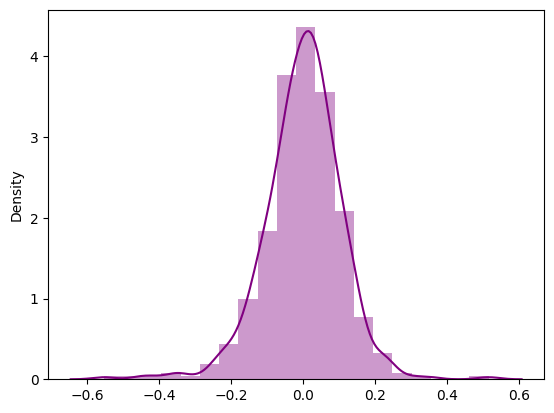

In [77]:
y_train_pred = lr_model_4.predict(X_train_sm)
residuals = y_train - y_train_pred
sns.distplot(residuals, bins=20, color='purple')
plt.show()

- <span style='color:green'>**Interpretation**</span>

  - Error Terms are normally distributed, with mean = 0

#### **Making Predictions using final model**

> `lr_model_4` is our final model

1) Rescale the test set

In [78]:
df_test[num_cols] = scaler.transform(df_test[num_cols])

2) Dividing into X_test and y_test

In [79]:
y_test = df_test.pop('cnt')
X_test = df_test

3) Select the shortlisted columns supported by RFE

In [80]:
X_test = X_test[rfe_selected_col]

4) Adding constant variable to test dataframe

In [81]:
X_test_upd = sm.add_constant(X_test)

5) Drop irrelavant columns from X_test_upd

In [82]:
X_test_upd.drop(["holiday", "weekday_Tuesday", "atemp"], axis = 1, inplace=True)

In [83]:
X_train_sm.shape, X_test_upd.shape

((510, 13), (219, 13))

6) Make predictions

In [84]:
y_pred_upd = lr_model_4.predict(X_test_upd)

#### **Model Evaluation**
  1) plot the graph for actual versus predicted values.

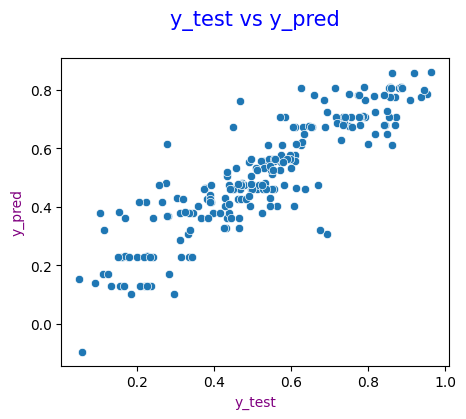

In [85]:
fig = plt.figure()
fig.set_size_inches(w=5, h=4)
sns.scatterplot(x=y_test, y=y_pred_upd)
plt.xlabel('y_test', fontsize=10, fontweight=20, color='purple')
plt.ylabel('y_pred', fontsize=10, fontweight=20, color='purple')
plt.title('y_test vs y_pred\n', fontsize=15, fontweight=20, color='blue')
plt.show()

- <span style='color:green'>**Interpretation**</span>

  - Estimated model built is able to fit the datapoints. Able to explain the variance of the target variable given the input variables on which it has regressed

#### <span style='color:purple'>**R-squared score on the test set**</span>

In [86]:
print(f'The R-squared score on test set is: {r2_score(y_test, y_pred_upd)}')

The R-squared score on test set is: 0.7788860632607986


- <span style='color:green'>Interpretation</span>:
  - About 77.88% of the variability of the target variable on test set is explained by the estimated model. 